In [1]:
import pandas as pd
import spacy
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from kaggle.api.kaggle_api_extended import KaggleApi
import seaborn as sns

In [2]:
api = KaggleApi()
api.authenticate()

In [3]:
api.competition_download_file('nlp-getting-started', 'train.csv', path='./')
api.competition_download_file('nlp-getting-started', 'test.csv', path='./')

ApiException: (401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 04 Jan 2021 20:56:25 GMT', 'Content-Length': '0', 'Set-Cookie': 'ka_sessionid=b0a6d78b00b0cbcaf2b52a28e4db20cd; max-age=2626560; path=/, GCLB=CKOsxYP7iLuOoAE; path=/; HttpOnly', 'Access-Control-Allow-Credentials': 'true', 'Turbolinks-Location': 'https://www.kaggle.com/api/v1/competitions/data/download/nlp-getting-started/train.csv', 'Strict-Transport-Security': 'max-age=63072000; includeSubDomains; preload', 'Content-Security-Policy': "object-src 'none'; script-src 'nonce-oktPzYU/zumeEONH/b42cQ==' 'report-sample' 'unsafe-inline' 'unsafe-eval' 'strict-dynamic' https: http:; frame-src 'self' https://www.kaggleusercontent.com https://www.youtube.com/embed/ https://polygraph-cool.github.io https://js.stripe.com https://www.google.com/recaptcha/ https://form.jotform.com https://submit.jotform.us https://submit.jotformpro.com https://submit.jotform.com https://www.docdroid.com https://www.docdroid.net https://kaggle-static.storage.googleapis.com https://kaggle-static-staging.storage.googleapis.com https://kkb-dev.jupyter-proxy.kaggle.net https://kkb-staging.jupyter-proxy.kaggle.net https://kkb-production.jupyter-proxy.kaggle.net https://kkb-production.firebaseapp.com https://apis.google.com https://content-sheets.googleapis.com/ https://accounts.google.com/ https://storage.googleapis.com https://docs.google.com; base-uri 'none'; report-uri https://csp.withgoogle.com/csp/kaggle/20201130;", 'X-Content-Type-Options': 'nosniff', 'Referrer-Policy': 'strict-origin-when-cross-origin', 'Via': '1.1 google', 'Alt-Svc': 'clear'})


In [4]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_train.target.mean()

0.4296597924602653

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
remove = ['id','keyword','location']
df_train = df_train.drop(remove, axis=1)

In [8]:
df_train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
nlp = en_core_web_sm.load()

In [10]:
STOP_WORDS.add("-PRON-")
STOP_WORDS.add("amp")
STOP_WORDS.add('s')

In [11]:
def cleaning_text_lemma(text):
    #return text
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    text = text.replace('#','hastag ')
    text = ''.join(char for char in text if char.isalnum() or char == ' ')
    text = text.replace(" +"," ").lower().strip()
    text = nlp(text)
    lemma = ' '.join([token.lemma_ for token in text if token.lemma_ not in STOP_WORDS])
    return lemma

def cleaning_text(text):
    #return text
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    text = text.replace('#','hastag ')
    text = text.replace('amp','')
    text = ''.join(char for char in text if char.isalnum() or char == ' ')
    text = text.replace(" +"," ").lower().strip()
    return text

def cleaning_bert(text):
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’#]))''', " ", text)
    text = text.replace('amp','')
    text = ''.join(char for char in text if char.isalnum() or char == ' ')
    text = text.replace(" +"," ").lower().strip()
    return text

In [12]:
df_train_clean_lemma = df_train.copy()
df_train_clean = df_train.copy()
df_train_bert = df_train.copy()

In [13]:
df_train_clean_lemma['text_clean'] = df_train_clean_lemma.text.apply(cleaning_text_lemma)
df_train_clean['text_clean'] = df_train_clean.text.apply(cleaning_text)
df_train_bert['text_clean'] = df_train_bert.text.apply(cleaning_bert)

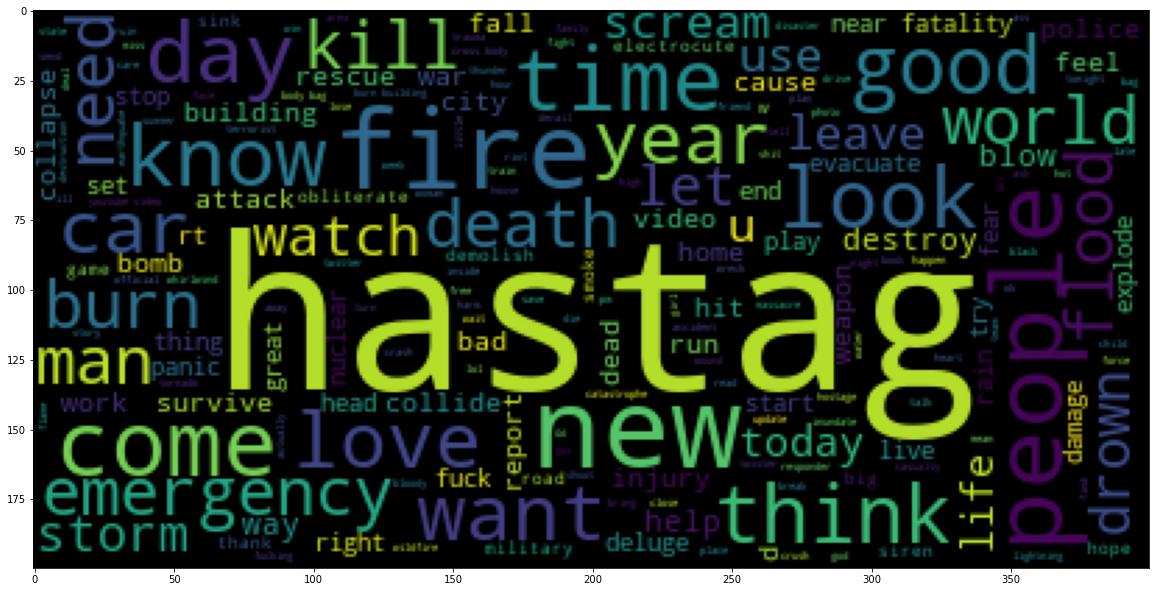

In [14]:
text_lemma = []
wd = WordCloud()
for c in df_train_clean_lemma.text_clean.value_counts().index:
    text_lemma.extend(c)
text_lemma = ''.join(text_lemma)
cloud = wd.generate(text_lemma)
plt.figure(figsize=(20,20))
plt.imshow(cloud)
plt.show()

In [15]:
seqlen_lemma = df_train_clean_lemma.text.apply(lambda x: len(x.split()))

C:\Users\froge\.conda\envs\gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='text', ylabel='Density'>

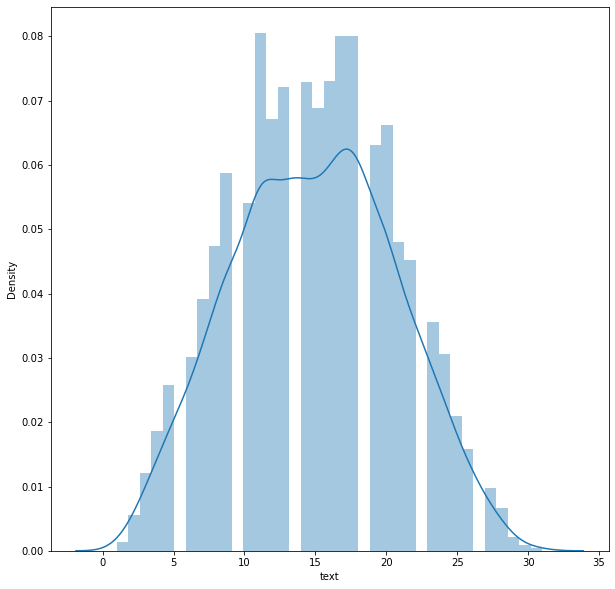

In [16]:
plt.figure(figsize=(10,10))
sns.distplot(seqlen_lemma)

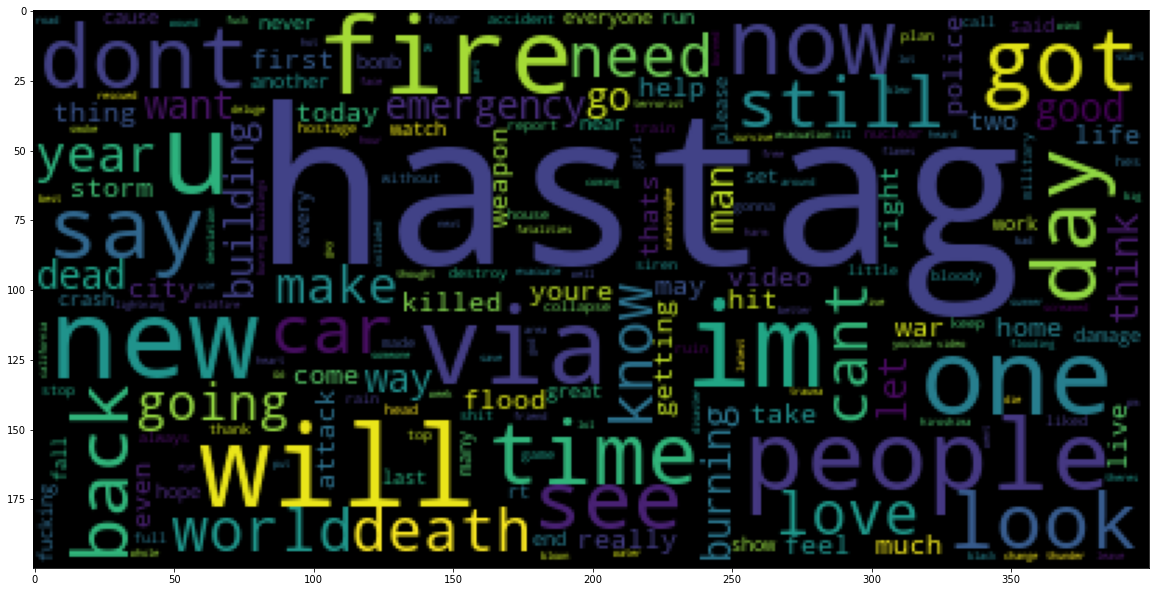

In [17]:
text = []
wd = WordCloud()
for c in df_train_clean.text_clean.value_counts().index:
    text.extend(c)
text = ''.join(text)
cloud = wd.generate(text)
plt.figure(figsize=(20,20))
plt.imshow(cloud)
plt.show()

In [18]:
seqlen = df_train_clean.text.apply(lambda x: len(x.split()))

C:\Users\froge\.conda\envs\gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='text', ylabel='Density'>

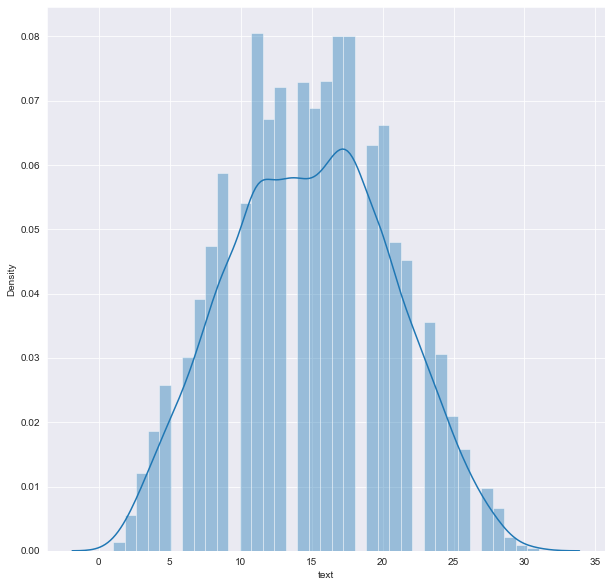

In [19]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,10))
sns.distplot(seqlen)

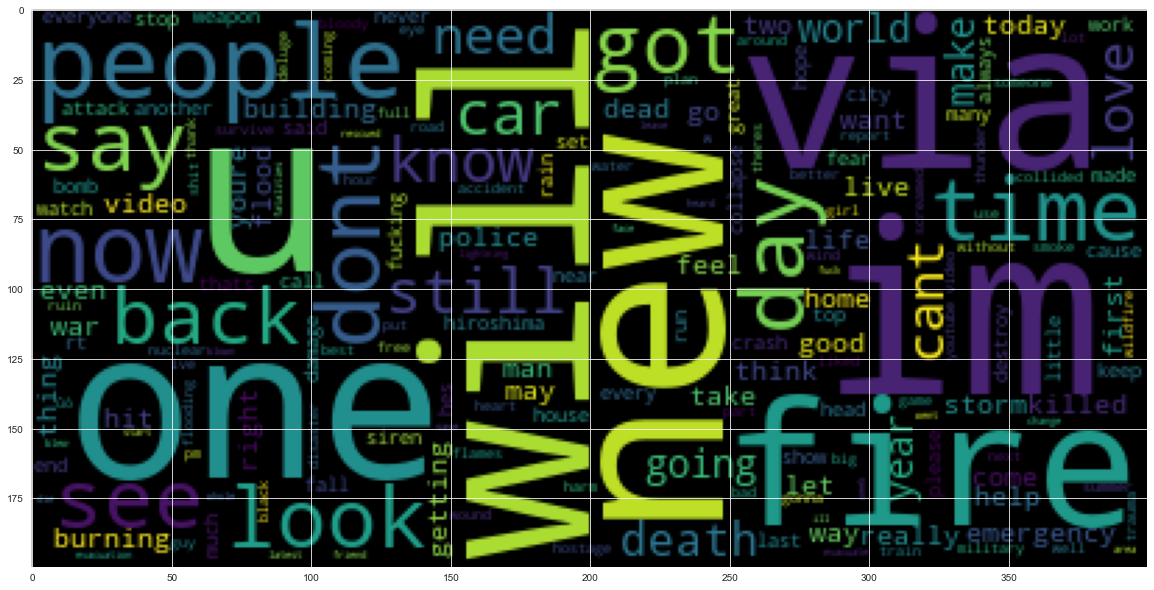

In [20]:
text = []
wd = WordCloud()
for c in df_train_bert.text_clean.value_counts().index:
    text.extend(c)
text = ''.join(text)
cloud = wd.generate(text)
plt.figure(figsize=(20,20))
plt.imshow(cloud)
plt.show()

In [21]:
seqlen = df_train_bert.text.apply(lambda x: len(x.split()))

C:\Users\froge\.conda\envs\gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='text', ylabel='Density'>

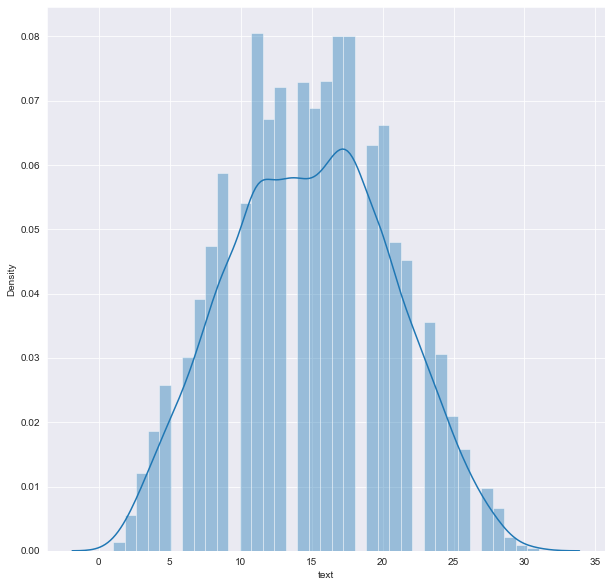

In [22]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,10))
sns.distplot(seqlen)

In [23]:
df_train_clean_lemma.to_csv('df_train_clean_lemma.csv',index=False)
df_train_clean.to_csv('df_train_clean.csv',index=False)
df_train_bert.to_csv('df_train_bert.csv',index=False)

In [24]:
import collections

In [25]:
def hastag(text):
    text_list = re.findall('#(\w+)', text)
    for i in range(len(text_list)):
        text_list[i] = text_list[i].replace('#','').lower()
    text_list = ' '.join([str(elem) for elem in text_list ])
    return text_list
   

In [26]:
df_hastag = df_train.copy()

In [27]:
df_hastag["hastag"] = df_hastag.text.apply(hastag)

In [28]:
df_hastag.head(20)

,text,target,hastag
0,Our Deeds are the Reason of this #earthquake M...,1,earthquake
1,Forest fire near La Ronge Sask. Canada,1,
2,All residents asked to 'shelter in place' are ...,1,
3,"13,000 people receive #wildfires evacuation or...",1,wildfires
4,Just got sent this photo from Ruby #Alaska as ...,1,alaska wildfires
5,#RockyFire Update => California Hwy. 20 closed...,1,rockyfire cafire wildfires
6,#flood #disaster Heavy rain causes flash flood...,1,flood disaster
7,I'm on top of the hill and I can see a fire in...,1,
8,There's an emergency evacuation happening now ...,1,
9,I'm afraid that the tornado is coming to our a...,1,


In [29]:
df_count_one = df_hastag[df_hastag.target == 1].hastag
df_count_one = df_count_one.to_frame()
df_count_zero = df_hastag[df_hastag.target == 0].hastag
df_count_zero = df_count_zero.to_frame()
df_count_one.reset_index(drop=True, inplace=True)
df_count_zero.reset_index(drop=True, inplace=True)

In [30]:
ligne = []
one = []
zero = []
for row in range(len(df_count_one)):
        ligne = df_count_one.hastag[row]
        one.append(ligne)
        ligne = df_count_zero.hastag[row]
        zero.append(ligne)

In [31]:
txt_one = " ".join(one)
txt_zero = " ".join(zero)

In [32]:
counts = collections.Counter(txt_one.split())
counts.most_common()

[('news', 56),
 ('hiroshima', 22),
 ('earthquake', 19),
 ('hot', 13),
 ('prebreak', 13),
 ('best', 13),
 ('japan', 11),
 ('india', 10),
 ('yyc', 10),
 ('breaking', 9),
 ('worldnews', 9),
 ('world', 9),
 ('isis', 9),
 ('sismo', 9),
 ('abstorm', 9),
 ('islam', 9),
 ('disaster', 8),
 ('wildfire', 8),
 ('terrorism', 8),
 ('fukushima', 8),
 ('mh370', 7),
 ('bbc', 7),
 ('genocide', 7),
 ('wx', 7),
 ('okwx', 7),
 ('hailstorm', 7),
 ('nuclear', 7),
 ('rohingya', 6),
 ('cnn', 6),
 ('africa', 6),
 ('antioch', 6),
 ('bestnaijamade', 6),
 ('wildfires', 5),
 ('newyork', 5),
 ('mumbai', 5),
 ('wmata', 5),
 ('myanmar', 5),
 ('sittwe', 5),
 ('drought', 5),
 ('libya', 5),
 ('pakistan', 5),
 ('science', 5),
 ('socialnews', 5),
 ('rockyfire', 4),
 ('flood', 4),
 ('california', 4),
 ('manchester', 4),
 ('accident', 4),
 ('tcot', 4),
 ('irandeal', 4),
 ('usa', 4),
 ('weather', 4),
 ('us', 4),
 ('zionist', 4),
 ('terrorist', 4),
 ('phoenix', 4),
 ('strategicpatience', 4),
 ('usgs', 4),
 ('hostages', 4),
 ('

In [33]:
counts = collections.Counter(txt_zero.split())
counts.most_common()

[('hot', 18),
 ('prebreak', 17),
 ('best', 17),
 ('jobs', 14),
 ('nowplaying', 13),
 ('gbbo', 12),
 ('job', 12),
 ('hiring', 10),
 ('islam', 10),
 ('news', 9),
 ('edm', 8),
 ('dnb', 8),
 ('beyhive', 8),
 ('directioners', 8),
 ('fashion', 8),
 ('rt', 7),
 ('dubstep', 7),
 ('trapmusic', 7),
 ('dance', 7),
 ('ices', 7),
 ('handbag', 7),
 ('military', 6),
 ('nursing', 6),
 ('armageddon', 5),
 ('mtvhottest', 5),
 ('kindle', 5),
 ('womens', 5),
 ('seattle', 5),
 ('technology', 5),
 ('np', 5),
 ('emmerdale', 5),
 ('soundcloud', 5),
 ('animalrescue', 5),
 ('nsfw', 4),
 ('lgbt', 4),
 ('tbt', 4),
 ('bb17', 4),
 ('irandeal', 4),
 ('chemical', 4),
 ('dependency', 4),
 ('course', 4),
 ('tubestrike', 4),
 ('free', 4),
 ('prophetmuhammad', 4),
 ('afterlife', 4),
 ('7', 4),
 ('ramag', 4),
 ('models', 4),
 ('mayhem', 4),
 ('mets', 3),
 ('pbban', 3),
 ('love', 3),
 ('us', 3),
 ('bluejays', 3),
 ('savebees', 3),
 ('business', 3),
 ('harrybecareful', 3),
 ('cool', 3),
 ('tech', 3),
 ('listen', 3),
 ('wors

In [38]:
df_hastag["noH"] = (df_hastag.hastag == '').astype(int)
df_hastag.head(10)

,text,target,hastag,noH
0,Our Deeds are the Reason of this #earthquake M...,1,earthquake,0
1,Forest fire near La Ronge Sask. Canada,1,,1
2,All residents asked to 'shelter in place' are ...,1,,1
3,"13,000 people receive #wildfires evacuation or...",1,wildfires,0
4,Just got sent this photo from Ruby #Alaska as ...,1,alaska wildfires,0
5,#RockyFire Update => California Hwy. 20 closed...,1,rockyfire cafire wildfires,0
6,#flood #disaster Heavy rain causes flash flood...,1,flood disaster,0
7,I'm on top of the hill and I can see a fire in...,1,,1
8,There's an emergency evacuation happening now ...,1,,1
9,I'm afraid that the tornado is coming to our a...,1,,1


In [35]:
df_hastag.groupby('noH').target.mean()

noH
0    0.492255
1    0.411073
Name: target, dtype: float64

In [36]:
df_hastag.groupby('noH').target.count()

noH
0    1743
1    5870
Name: target, dtype: int64